# Pneumonia Detection from Chest X-rays

Simple CNN model trained from scratch for binary classification.

## Overview
- **Model**: Custom CNN (no pre-trained weights)
- **Task**: Binary Classification (Normal vs Pneumonia)
- **Framework**: TensorFlow/Keras
- **Features**: Data augmentation, dropout, checkpointing, learning rate scheduling


## 1. Import Required Libraries


In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow: {tf.__version__}")
print(f"GPU: {len(tf.config.list_physical_devices('GPU')) > 0}")


TensorFlow: 2.20.0
GPU: False


## 2. Configuration and Hyperparameters


In [12]:
# Paths
TRAIN_DIR = './data/train'
VAL_DIR = './data/val'

# Hyperparameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 0.0001

# Model configuration
MODEL_NAME = 'ResNet50'  # Options: 'ResNet50', 'VGG16', 'EfficientNetB0'
FREEZE_LAYERS = True  # Freeze base model layers initially

print(f"Training Directory: {TRAIN_DIR}")
print(f"Validation Directory: {VAL_DIR}")
print(f"Image Size: {IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Model: {MODEL_NAME}")


Training Directory: ./data/train
Validation Directory: ./data/val
Image Size: (224, 224)
Batch Size: 32
Model: ResNet50


## 3. Data Augmentation


In [13]:
# Training with augmentation
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation without augmentation
val_gen = ImageDataGenerator(rescale=1./255)

train_ds = train_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_ds = val_gen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print(f"Train samples: {train_ds.samples}")
print(f"Val samples: {val_ds.samples}")
print(f"Classes: {train_ds.class_indices}")


Found 42 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Train samples: 42
Val samples: 16
Classes: {'NORMAL': 0, 'PNEUMONIA': 1}


## 4. Build CNN Model


In [14]:
# Simple CNN with regularization
model = Sequential([
    # Block 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(*IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    # Block 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    # Block 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    # Dense layers
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


c:\Users\abasi\Desktop\medical-imaging\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,497 (42.61 MB)

 Trainable params: 11,169,793 (42.61 MB)

 Non-trainable params: 704 (2.75 KB)

## 5. Callbacks (Checkpointing, Learning Rate, Early Stopping)


In [15]:
# Checkpoint: Save best model
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Learning rate reduction
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

callbacks = [checkpoint, reduce_lr, early_stop]


## 6. Train Model


In [16]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining complete!")


Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.4762 - loss: 1.3899 
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 48s 24s/step - accuracy: 0.4683 - loss: 1.3996 - val_accuracy: 0.5000 - val_loss: 0.6969 - learning_rate: 1.0000e-04
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6146 - loss: 0.9117  
Epoch 2: val_accuracy did not improve from 0.50000
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.6319 - loss: 0.8805 - val_accuracy: 0.5000 - val_loss: 0.6977 - learning_rate: 1.0000e-04
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6771 - loss: 0.7530
Epoch 3: val_accuracy improved from 0.50000 to 0.56250, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 9s/step - accuracy: 0.6736 - loss: 0.7555 - val_accuracy: 0.5625 - val_loss: 0.6906 - learning_rate: 1.0000e-04
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8429 - loss: 0.4737
Epoch 4: val_accuracy did not improve from 0.56250
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 10s/step - accuracy: 0.8238 - loss: 0.5087 - val_accuracy: 0.5000 - val_loss: 0.6964 - learning_rate: 1.0000e-04
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7452 - loss: 0.6503
Epoch 5: val_accuracy did not improve from 0.56250
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 9s/step - accuracy: 0.7270 - loss: 0.6708 - val_accuracy: 0.5000 - val_loss: 0.7599 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 3.

Training complete!


## 7. Training Results


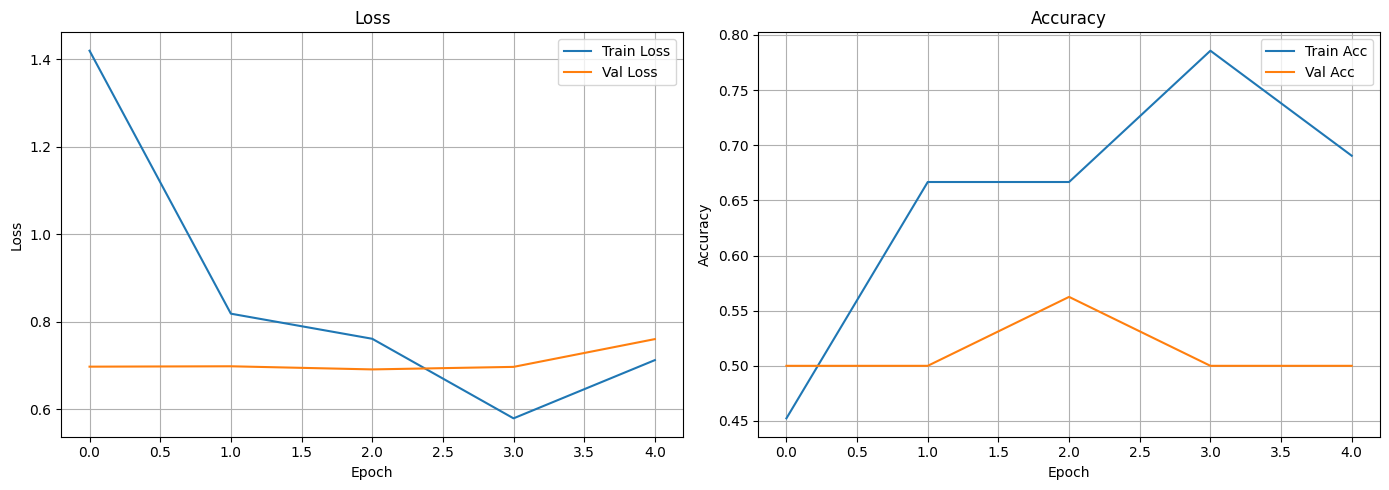


Final Training Accuracy: 0.6905
Final Validation Accuracy: 0.5000


In [17]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Val Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy
ax2.plot(history.history['accuracy'], label='Train Acc')
ax2.plot(history.history['val_accuracy'], label='Val Acc')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
print(f"\nFinal Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")


## 8. Evaluate Model


In [18]:
# Evaluate on validation set
val_loss, val_acc = model.evaluate(val_ds)
print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5625 - loss: 0.6906   

Validation Loss: 0.6906
Validation Accuracy: 0.5625


## 9. Save Model


In [19]:
model.save('pneumonia_model.h5')
print("Model saved as 'pneumonia_model.h5'")


Model saved as 'pneumonia_model.h5'
